# Pylops - Radon on GPU with cupy

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import numpy as np
import cupy as cp
import scipy as sp
import cusignal
import matplotlib.pyplot as plt

from scipy.sparse.linalg import inv, lsqr
from scipy.sparse import rand

from pylops.utils import dottest
from pylops.utils.seismicevents import *
from pylops.utils.wavelets import *
from pylops import LinearOperator
from pylops.basicoperators import *
from pylops.signalprocessing import *
from pylops.optimization.basic import cgls
from pylops.optimization.leastsquares import *
from pylops.optimization.sparsity import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# Create axis
par = {'ot': 0,    'dt': 0.004, 'nt': 501,
       'ox': -250, 'dx': 2, 'nx': 251,
       'oy': -250, 'dy': 2, 'ny': 251,
       'f0': 40}
theta = [20, ]
t0 = [0.8, ]
amp = [1., ]

# Create axis
t, t2, x, y = makeaxis(par)
dt, dx, dy = par['dt'], par['dx'], par['dy']

# Create wavelet
wav, _, wav_c = ricker(t[:41], f0=par['f0'])

# Generate model
_, d = linear2d(x, t, 1500., t0, theta, amp, wav)

d = cp.array(d)

In [5]:
npx, pxmax = par['nx'], 5e-4
px = np.linspace(-pxmax, pxmax, npx)

R2Op = ChirpRadon2D(t, x, pxmax*dx/dt, dtype='float64')
dL_chirp = R2Op * d.ravel()
dadj_chirp = R2Op.H * dL_chirp
dinv_chirp = R2Op.inverse(dL_chirp)

dL_chirp = dL_chirp.reshape(par['nx'], par['nt'])
dadj_chirp = dadj_chirp.reshape(par['nx'], par['nt'])
dinv_chirp = dinv_chirp.reshape(par['nx'], par['nt'])

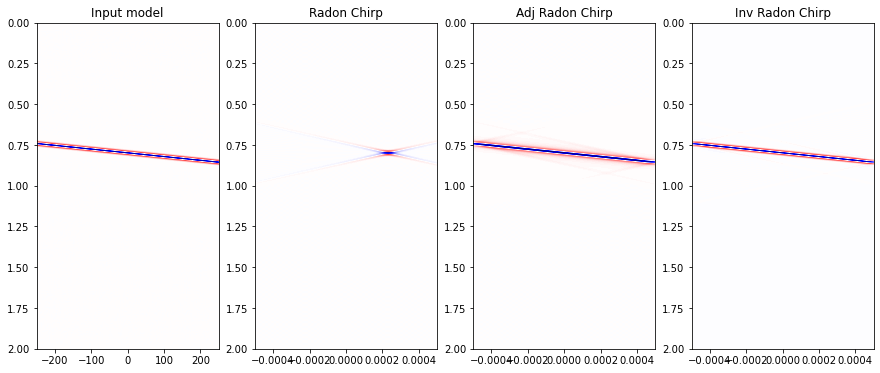

In [6]:
fig, axs = plt.subplots(1, 4, figsize=(15, 6))
axs[0].imshow(cp.asnumpy(d).T, vmin=-1, vmax=1, cmap='seismic_r',
              extent=(x[0], x[-1], t[-1], t[0]))
axs[0].set_title('Input model')
axs[0].axis('tight')
axs[1].imshow(cp.asnumpy(dL_chirp).T, cmap='seismic_r', vmin=-dL_chirp.max(), vmax=dL_chirp.max(),
              extent=(px[0], px[-1], t[-1], t[0]))
axs[1].set_title('Radon Chirp')
axs[1].axis('tight')
axs[2].imshow(cp.asnumpy(dadj_chirp).T, cmap='seismic_r', vmin=-dadj_chirp.max(), vmax=dadj_chirp.max(),
              extent=(px[0], px[-1], t[-1], t[0]))
axs[2].set_title('Adj Radon Chirp')
axs[2].axis('tight')
axs[3].imshow(cp.asnumpy(dinv_chirp).T, cmap='seismic_r', vmin=-d.max(), vmax=d.max(),
              extent=(px[0], px[-1], t[-1], t[0]))
axs[3].set_title('Inv Radon Chirp')
axs[3].axis('tight');

In [7]:
d_np = cp.asnumpy(d) 

%timeit -n2 -r2 R2Op * d.ravel()
%timeit -n2 -r2 R2Op * d_np.ravel()

1.32 ms ± 202 µs per loop (mean ± std. dev. of 2 runs, 2 loops each)
44.2 ms ± 3.4 ms per loop (mean ± std. dev. of 2 runs, 2 loops each)


In [8]:
par = {'ot': 0,    'dt': 0.004, 'nt': 201,
       'ox': -625, 'dx': 12.5, 'nx': 101,
       'oy': -625, 'dy': 12.5, 'ny': 101,
       'f0': 20}
theta = [0, ]
t0 = [0.5, ]
amp = [1., ]

# Create axis
t, t2, x, y = makeaxis(par)
dt, dx, dy = par['dt'], par['dx'], par['dy']

# Create wavelet
wav = ricker(t[:41], f0=par['f0'])[0]

# Generate model
_, d = linear3d(x, y, t, 1500., t0, theta, [0, ], amp, wav)

d = cp.array(d)

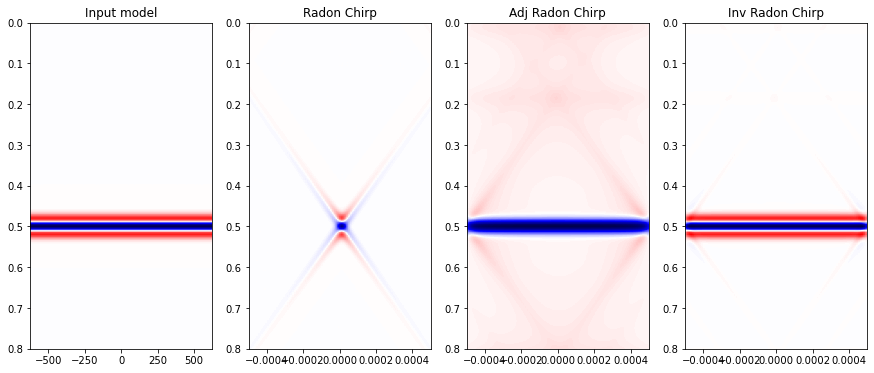

In [9]:
npy, pymax = par['ny'], 5e-4
npx, pxmax = par['nx'], 5e-4

py = np.linspace(-pymax, pymax, npy)
px = np.linspace(-pxmax, pxmax, npx)

R3Op = ChirpRadon3D(t, y, x, (pymax*dy/dt, pxmax*dx/dt), dtype='float64')

dL_chirp = R3Op * d.ravel()
dadj_chirp = R3Op.H * dL_chirp
dinv_chirp = R3Op.inverse(dL_chirp)

dL_chirp = dL_chirp.reshape(par['ny'], par['nx'], par['nt'])
dadj_chirp = dadj_chirp.reshape(par['ny'], par['nx'], par['nt'])
dinv_chirp = dinv_chirp.reshape(par['ny'], par['nx'], par['nt'])

fig, axs = plt.subplots(1, 4, figsize=(15, 6))
axs[0].imshow(cp.asnumpy(d[par['ny']//2]).T, vmin=-1, vmax=1, cmap='seismic_r',
              extent=(x[0], x[-1], t[-1], t[0]))
axs[0].set_title('Input model')
axs[0].axis('tight')
axs[1].imshow(cp.asnumpy(dL_chirp[npy//2]).T, cmap='seismic_r', vmin=-dL_chirp.max(), vmax=dL_chirp.max(),
              extent=(px[0], px[-1], t[-1], t[0]))
axs[1].set_title('Radon Chirp')
axs[1].axis('tight')
axs[2].imshow(cp.asnumpy(dadj_chirp[npy//2]).T, cmap='seismic_r', vmin=-dadj_chirp.max(), vmax=dadj_chirp.max(),
              extent=(px[0], px[-1], t[-1], t[0]))
axs[2].set_title('Adj Radon Chirp')
axs[2].axis('tight')
axs[3].imshow(cp.asnumpy(dinv_chirp[npy//2]).T, cmap='seismic_r', vmin=-d.max(), vmax=d.max(),
              extent=(px[0], px[-1], t[-1], t[0]))
axs[3].set_title('Inv Radon Chirp')
axs[3].axis('tight');

In [10]:
d_np = cp.asnumpy(d) 

%timeit -n2 -r2 R3Op * d.ravel()
%timeit -n2 -r2 R3Op * d_np.ravel()

1.37 ms ± 198 µs per loop (mean ± std. dev. of 2 runs, 2 loops each)
1.44 s ± 4.88 ms per loop (mean ± std. dev. of 2 runs, 2 loops each)
